# Выбор локации для скважины

Нам нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
 - `id` — уникальный идентификатор скважины
 - `f0, f1, f2` — три признака точек
 - `product` — объём запасов в скважине (тыс. баррелей). Это наш целевой признак

**Условия задачи**
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.



In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings

from seaborn.algorithms import bootstrap
from sklearn.impute import SimpleImputer

# Импорт для масштабирования и кодирования данных
from sklearn.preprocessing import (
    # Масштабирование числовых значений
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
)

# Импорт линейных моделей
from sklearn.linear_model import (
    LinearRegression
)

from sklearn.dummy import DummyRegressor

# Импорт для подбора гиперпараметров модели и разбиения на выборки
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

# Импорт для расчета метрик
from sklearn.metrics import (
    make_scorer,
    mean_squared_error
)

# Импорт для создания пайплайнов
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# pd.options.display.float_format = '{:,.1f}'.format
warnings.filterwarnings('ignore')
RANDOM_STATE = np.random.RandomState(42)

## Загрузка и подготовка данных

In [3]:
# Импортируем данные
try:
    geo_0 = pd.read_csv('data/geo_data_0.csv')
    geo_1 = pd.read_csv('data/geo_data_1.csv')
    geo_2 = pd.read_csv('data/geo_data_2.csv')
except:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

# Указываем имена для того, чтобы можно было вызвать их в цикле
geo_0.name = 'geo_0'
geo_1.name = 'geo_1'
geo_2.name = 'geo_2'

### Вывод общей информации

In [4]:
def get_info(df):
    print(f'\n\nКоличество неявных дубликатов в {df.name}: {df.duplicated().sum()}')
    print(f'Количество уникальных значений id в {df.name}: {df["id"].nunique()}\n')
    print(df.info())
    print(df.head())
    print('-'*50)

In [5]:
for df in [geo_0, geo_1, geo_2]:
    get_info(df)



Количество неявных дубликатов в geo_0: 0
Количество уникальных значений id в geo_0: 99990

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
--------------------------------------------------


Количество неявных дубликатов в geo_1: 0
Количество уникальных значений id в geo_1: 99996

<class 'pandas.cor

Все данные приведены к нужному типу данных. Пропуски в столбцах у нас отсутствуют

### Исследовательский анализ данных

Посмотрим на наличие выбросов в данных, а так же на то, как эти данных распределены

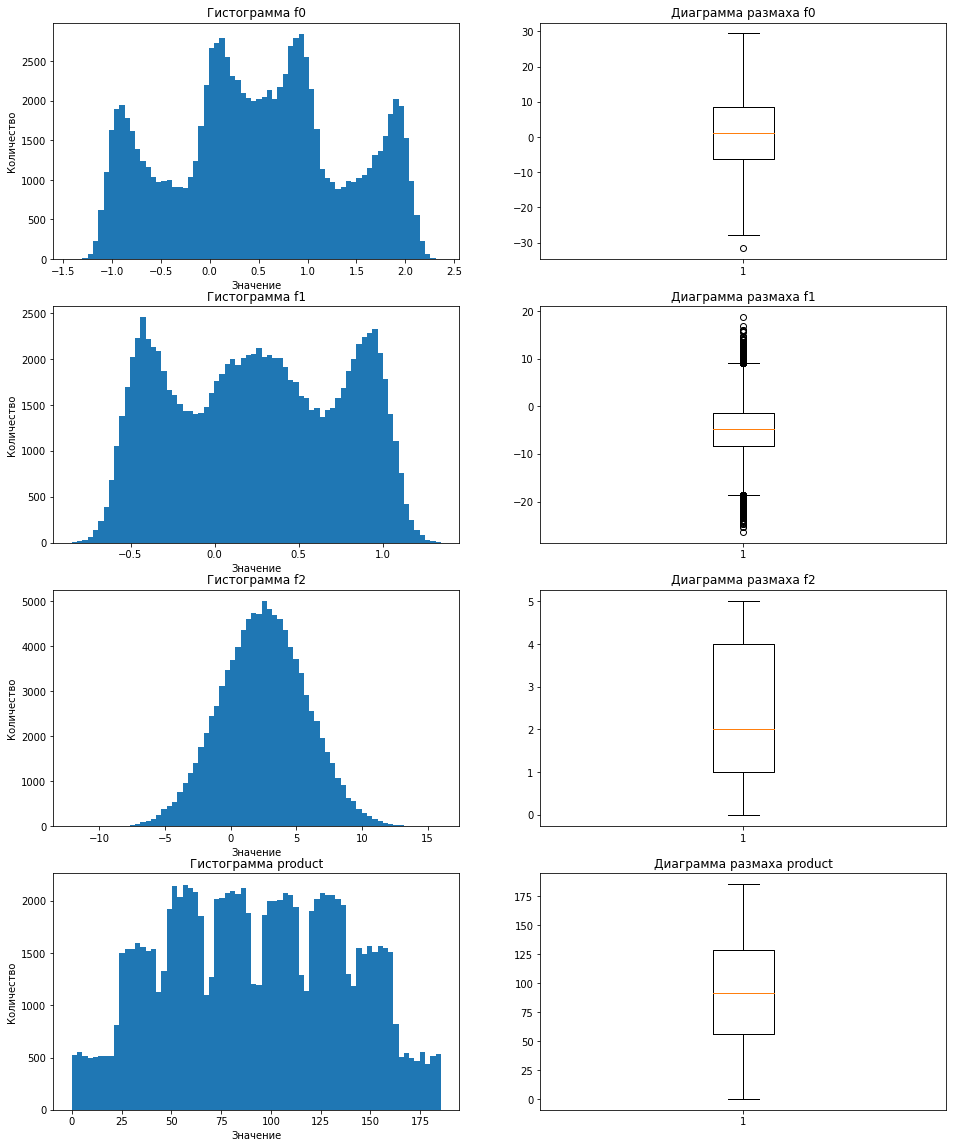

In [7]:
# Анализ значений для geo_0
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

ax[0, 0].hist(geo_0['f0'], bins=70)
ax[0, 0].set_title('Гистограмма f0')
ax[0, 0].set_xlabel('Значение')
ax[0, 0].set_ylabel('Количество')
ax[0, 1].boxplot(geo_1['f0'])
ax[0, 1].set_title('Диаграмма размаха f0')

ax[1, 0].hist(geo_0['f1'], bins=70)
ax[1, 0].set_title('Гистограмма f1')
ax[1, 0].set_xlabel('Значение')
ax[1, 0].set_ylabel('Количество')
ax[1, 1].boxplot(geo_1['f1'])
ax[1, 1].set_title('Диаграмма размаха f1')

ax[2, 0].hist(geo_0['f2'], bins=70)
ax[2, 0].set_title('Гистограмма f2')
ax[2, 0].set_xlabel('Значение')
ax[2, 0].set_ylabel('Количество')
ax[2, 1].boxplot(geo_1['f2'])
ax[2, 1].set_title('Диаграмма размаха f2')

ax[3, 0].hist(geo_0['product'], bins=70)
ax[3, 0].set_title('Гистограмма product')
ax[3, 0].set_xlabel('Значение')
ax[3, 0].set_ylabel('Количество')
ax[3, 1].boxplot(geo_0['product'])
ax[3, 1].set_title('Диаграмма размаха product')

plt.show()

- `f0` - Бимодальное распределение с двумя пиками около 0 и 1
- `f1` - Также бимодальное распределение, но с меньшим разбросом значений.
- `f2` - Нормальное распределение с одним пиком около нуля.
- `product` - Распределение с несколькими пиками, указывающее на наличие нескольких групп данных.

В столбце `f1` присутствуют выбросы, однако среди них нет экстремальных значений, так что оставим их, чтобы у модели были более разнообразные данные для обучения

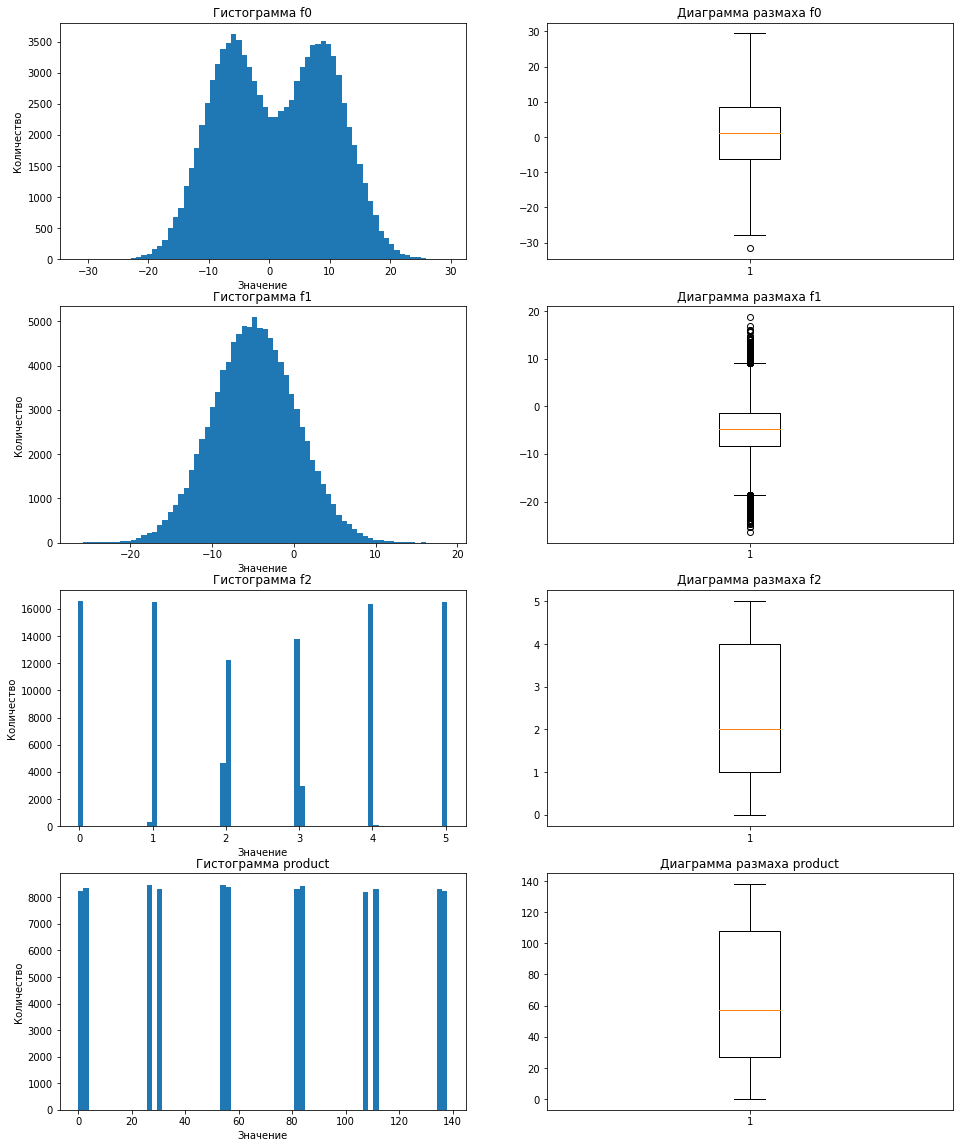

In [8]:
# Анализ значений для geo_1
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

ax[0, 0].hist(geo_1['f0'], bins=70)
ax[0, 0].set_title('Гистограмма f0')
ax[0, 0].set_xlabel('Значение')
ax[0, 0].set_ylabel('Количество')
ax[0, 1].boxplot(geo_1['f0'])
ax[0, 1].set_title('Диаграмма размаха f0')

ax[1, 0].hist(geo_1['f1'], bins=70)
ax[1, 0].set_title('Гистограмма f1')
ax[1, 0].set_xlabel('Значение')
ax[1, 0].set_ylabel('Количество')
ax[1, 1].boxplot(geo_1['f1'])
ax[1, 1].set_title('Диаграмма размаха f1')

ax[2, 0].hist(geo_1['f2'], bins=70)
ax[2, 0].set_title('Гистограмма f2')
ax[2, 0].set_xlabel('Значение')
ax[2, 0].set_ylabel('Количество')
ax[2, 1].boxplot(geo_1['f2'])
ax[2, 1].set_title('Диаграмма размаха f2')

ax[3, 0].hist(geo_1['product'], bins=70)
ax[3, 0].set_title('Гистограмма product')
ax[3, 0].set_xlabel('Значение')
ax[3, 0].set_ylabel('Количество')
ax[3, 1].boxplot(geo_1['product'])
ax[3, 1].set_title('Диаграмма размаха product')

plt.show()

- `f0` - Бимодальное распределение с двумя пиками около -10 и 10
- `f1` - Нормальное распределение

В столбце `f1` присутствуют выбросы, однако среди них нет экстремальных значений, так что оставим их, чтобы у модели были более разнообразные данные для обучения

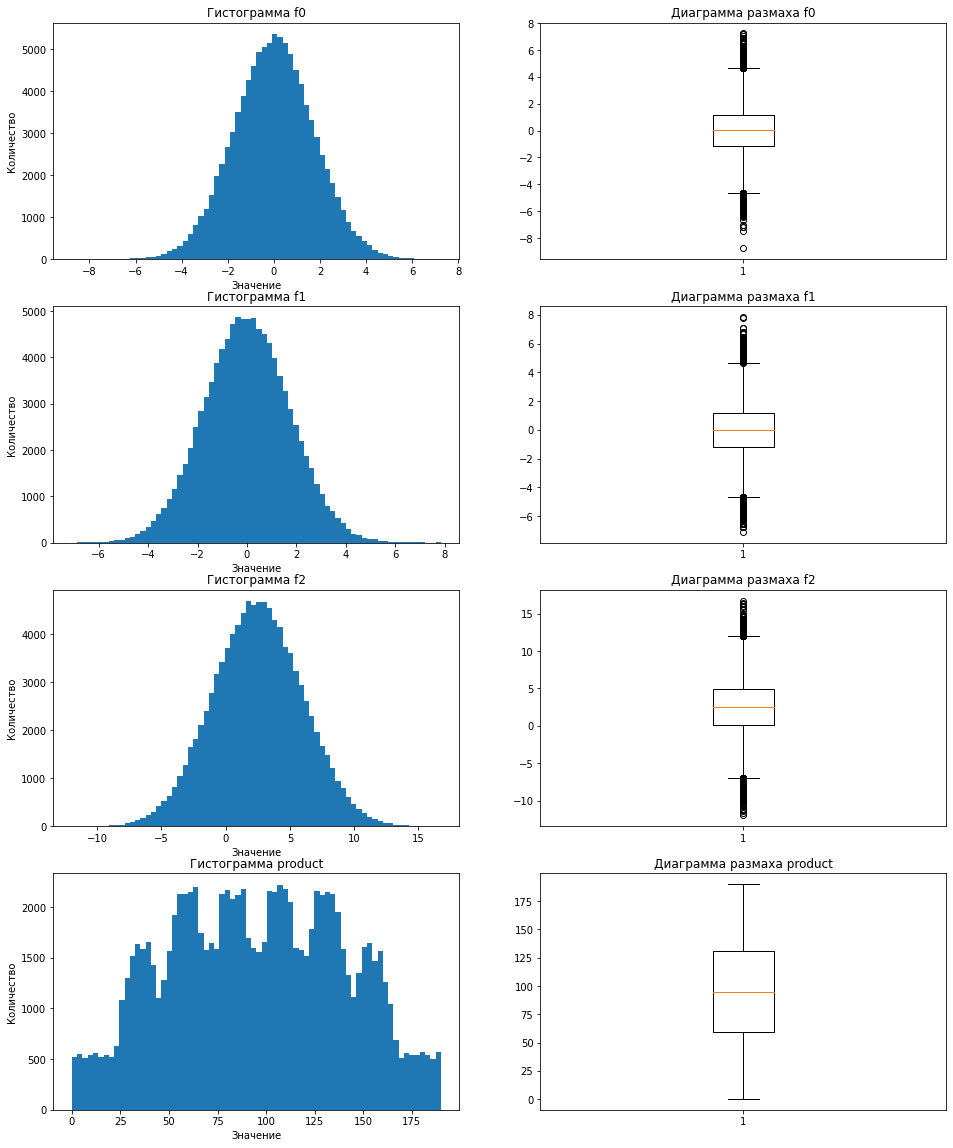

In [9]:
# Анализ значений для geo_2
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

ax[0, 0].hist(geo_2['f0'], bins=70)
ax[0, 0].set_title('Гистограмма f0')
ax[0, 0].set_xlabel('Значение')
ax[0, 0].set_ylabel('Количество')
ax[0, 1].boxplot(geo_2['f0'])
ax[0, 1].set_title('Диаграмма размаха f0')

ax[1, 0].hist(geo_2['f1'], bins=70)
ax[1, 0].set_title('Гистограмма f1')
ax[1, 0].set_xlabel('Значение')
ax[1, 0].set_ylabel('Количество')
ax[1, 1].boxplot(geo_2['f1'])
ax[1, 1].set_title('Диаграмма размаха f1')

ax[2, 0].hist(geo_2['f2'], bins=70)
ax[2, 0].set_title('Гистограмма f2')
ax[2, 0].set_xlabel('Значение')
ax[2, 0].set_ylabel('Количество')
ax[2, 1].boxplot(geo_2['f2'])
ax[2, 1].set_title('Диаграмма размаха f2')

ax[3, 0].hist(geo_2['product'], bins=70)
ax[3, 0].set_title('Гистограмма product')
ax[3, 0].set_xlabel('Значение')
ax[3, 0].set_ylabel('Количество')
ax[3, 1].boxplot(geo_2['product'])
ax[3, 1].set_title('Диаграмма размаха product')

plt.show()

- `f0` - Нормальное распределение с пиком около нуля и симметричным спадом в обе стороны
- `f1` - Также нормальное распределение, но с меньшим разбросом значений и пиком около нуля
- `f2` - Нормальное распределение с пиком около нуля и более широким разбросом по сравнению с f0 и f1
- `product` - Распределение с несколькими пиками, указывающее на наличие нескольких групп данных

Во всех столбцах, кроме последнего, присутствуют выбросы. Аналогично с прошлыми датафреймами, оставим их, чтобы модель получила больше данных

### Корреляционный анализ

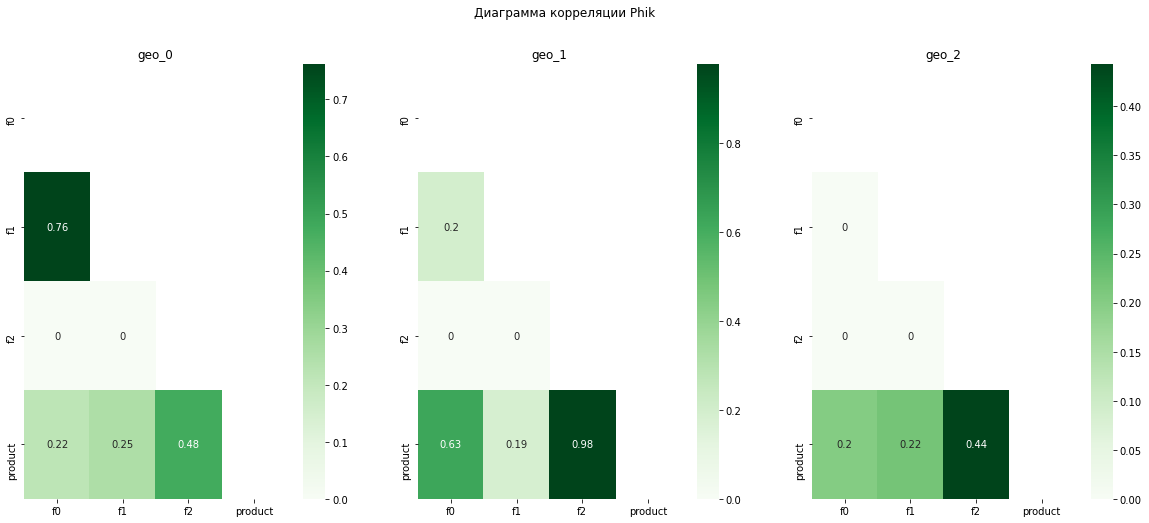

In [10]:
# Создадим хитмап корреляции
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.heatmap(
    geo_0.drop('id', axis=1).phik_matrix(
        interval_cols=['f0', 'f1', 'f2', 'product']
    ),
    annot=True, cmap='Greens', ax=ax[0],
    mask=(np.triu(
        np.ones_like(geo_0.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']), dtype=bool)))
)
ax[0].set_title('geo_0')

sns.heatmap(
    geo_1.drop('id', axis=1).phik_matrix(
        interval_cols=['f0', 'f1', 'f2', 'product']
    ),
    annot=True, cmap='Greens', ax=ax[1],
    mask=(np.triu(
        np.ones_like(geo_1.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']), dtype=bool)))
)
ax[1].set_title('geo_1')

sns.heatmap(
    geo_2.drop('id', axis=1).phik_matrix(
        interval_cols=['f0', 'f1', 'f2', 'product']
    ),
    annot=True, cmap='Greens', ax=ax[2],
    mask=(np.triu(
        np.ones_like(geo_2.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']), dtype=bool)))
)
ax[2].set_title('geo_2')

plt.suptitle('Диаграмма корреляции Phik')
plt.show()

1. `geo_0` - больше всего признак `f0` коррелирует с признаком `f1`. `product` имеет умеренно-низкую корреляцию со всеми признаками
2. `geo_1` - больше всего признак `product` коррелирует с признаком `f2`. Корреляция составляет почти 1, потому впоследствии при обучении модели могут возникнуть проблемы.
3. `geo_2` - `product` умеренно-низко коррелирует со всеми признаками. Сами же признаки между собой не коррелируют

### Промежуточный вывод:

- Мы загрузили данные
- Во время обработки дубликатов, мы не нашли явных дубликатов, однако среди уникальных id нашли несколько неявных дубликатов, которые скорее всего вызваны каким-то техническим сбоем
- Во время исследовательского анализа, мы выяснили, что большинство данных распределено нормально, некоторые из них имеют несколько пиков, что говорит о биноминальном распределении. Выбросы в данных мы оставили, так как там нет экстремальных значений, которые могут значительно ухудшить данные модели. Оставив выбросы, мы позволим модели учиться не в "идеальных" условиях.
- Во время корреляционного анализа мы увидели, мы увидели, что в датафрейме `geo_1` признак `f2` мультиколлинеарен с признаком `product`. В большинстве своем признаки имеют умеренно-низкую корреляцию

## Обучение и проверка модели

Создадим пайплайн для обучения модели, проверив качество через кросс-валидацию

### Создание пайплайна

In [11]:
# Список столбцов с числовыми значениями
num_columns = ['f0', 'f1', 'f2']

# Пайплайн для числовых значений
num_pipeline = Pipeline(
    [
        (
            'imputer_before_scaler',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'num',
            StandardScaler()
        ),
    ]
)

# Создаем препроцессор
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_columns),
    ],
    remainder='passthrough',
)

# Собираем финальный пайплайн
final_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DummyRegressor(strategy='median')),
    ]
)

In [12]:
# Создаем сетку гиперпараметров
param_grid = [
    {
        'models': [DummyRegressor()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        'models__strategy': ['most_frequent', 'median', 'mean'],
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
    }
]

In [13]:
# Создаем пользовательскую метрику RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [14]:
random_search = RandomizedSearchCV(
    final_pipeline,
    param_distributions=param_grid,
    cv=5,
    scoring=rmse_scorer,
)

### Обучение модели

In [15]:
# Создадим таблицу с реальными и предсказанными данными
predictions = pd.DataFrame()

In [16]:
X_train_geo_0, X_valid_geo_0, y_train_geo_0, y_valid_geo_0 = train_test_split(
    geo_0.drop(['id', 'product'], axis=1),
    geo_0['product'],
    test_size=0.25, random_state=RANDOM_STATE
)

# Создаем таблицу для предсказаний
predictions['geo_0_true'] = y_valid_geo_0.reset_index(drop=True)

random_search.fit(X_train_geo_0, y_train_geo_0)
print('RMSE:', -random_search.best_score_)

# Добавляем предсказание для первой локации
predictions['geo_0_pred'] = random_search.predict(X_valid_geo_0)

random_search

RMSE: 37.67200536313506


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer_before_scaler',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('num',
                                                                                                StandardScaler())]),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])]

In [17]:
X_train_geo_1, X_valid_geo_1, y_train_geo_1, y_valid_geo_1 = train_test_split(
    geo_1.drop(['id', 'product'], axis=1),
    geo_1['product'],
    test_size=0.25, random_state=RANDOM_STATE
)

# Создаем таблицу для предсказаний
predictions['geo_1_true'] = y_valid_geo_1.reset_index(drop=True)

random_search.fit(X_train_geo_1, y_train_geo_1)
print('RMSE:', -random_search.best_score_)

# Добавляем предсказание для второй локации
predictions['geo_1_pred'] = random_search.predict(X_valid_geo_1)

random_search

RMSE: 0.8905865307911203


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer_before_scaler',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('num',
                                                                                                StandardScaler())]),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])]

In [19]:
X_train_geo_2, X_valid_geo_2, y_train_geo_2, y_valid_geo_2 = train_test_split(
    geo_2.drop(['id', 'product'], axis=1),
    geo_2['product'],
    test_size=0.25, random_state=RANDOM_STATE
)

# Создаем таблицу для предсказаний
predictions['geo_2_true'] = y_valid_geo_2.reset_index(drop=True)

random_search.fit(X_train_geo_2, y_train_geo_2)
print('RMSE:', -random_search.best_score_)

# Добавляем предсказание для третьей локации
predictions['geo_2_pred'] = random_search.predict(X_valid_geo_2)

random_search

RMSE: 39.995888582524245


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer_before_scaler',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('num',
                                                                                                StandardScaler())]),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])]

In [20]:
predictions.head()

,geo_0_true,geo_0_pred,geo_1_true,geo_1_pred,geo_2_true,geo_2_pred
0,122.073350,101.901017,137.945408,136.980500,12.129573,103.253098
1,48.738540,78.217774,30.132364,29.796653,111.758783,120.537785
2,131.338088,115.266901,26.953261,27.109922,69.146198,108.464791
3,88.327757,105.618618,84.038886,83.969079,148.901905,102.507935
4,36.959266,97.980185,57.085625,56.500323,53.445327,85.070567


In [21]:
# Выводим среднее
print('Среднее geo_0_true:', predictions['geo_0_true'].mean())
print('Среднее geo_0_pred:', predictions['geo_0_pred'].mean())
print()
print('Среднее geo_1_true:', predictions['geo_1_true'].mean())
print('Среднее geo_1_pred:', predictions['geo_1_pred'].mean())
# print('Среднее geo_1_without_f2_pred:', predictions['geo_1_without_f2_pred'].mean())
print()
print('Среднее geo_2_true:', predictions['geo_2_true'].mean())
print('Среднее geo_2_pred:', predictions['geo_2_pred'].mean())

Среднее geo_0_true: 92.32595637084387
Среднее geo_0_pred: 92.39879990657768

Среднее geo_1_true: 68.59968732439852
Среднее geo_1_pred: 68.58780312701154

Среднее geo_2_true: 95.03521872476617
Среднее geo_2_pred: 95.09230341410031


Мы можем видеть, что среднее значение предсказанных значений почти не отличается от среднего истинных значений. Во время проверки на валидационной выборке, мы получили следующие значение RMSE для каждой таблицы:
 - `geo_0` — 37.7
 - `geo_1` — 0.9
 - `geo_1_without_f2` — 45.8
 - `geo_2` — 40\

Это означает, что модель в среднем отклоняется на 40 единиц от истинного значения. Стоит так же отметить, что в таблице `geo_1` без целевого признака `f2` ошибка сильно возрастает, так как этот признак мультиколлинеарен с целевым признаком

### Промежуточный вывод:
Мы создали пайплайн для предсказания объема запасов в скважине. Лидером является `geo_2` со средним значением запасов, равным `95`. Далее идет `geo_0` со средним значением запасов, равным `92`. Меньше всего запасов в точке `geo_1` со средним значением запасов, равным `69`. Средние значения предсказанных значений почти не отличаются от среднего истинных значений. `RMSE` в среднем составляет 40, что означает отклонение предсказания от целевого признака на 40 тыс. баррелей

## Подготовка к расчёту прибыли

- Сохраним все ключевые значения для расчётов в отдельных переменных.
- Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.
- Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели


In [22]:
# Объявляем константы
POINTS = 500
BEST_POINTS = 200

BUDGET = 10 * 10 ** 9
PROFIT_PER_PRODUCT = 450 * 10 ** 3

BOOTSTRAP_ITERATIONS = 1000

LOSS_THRESHOLD = 0.025

In [23]:
cost_per_point = BUDGET / BEST_POINTS
lossless_threshold = cost_per_point / PROFIT_PER_PRODUCT
print(f'Минимальный объем сырья для безубыточной разработки: {lossless_threshold:.2f} тыс. баррелей\n')

# Считаем средний объем запасов для каждой точки
for df in [geo_0, geo_1, geo_2]:
    print(f'Средний объем сырья для {df.name}: {df["product"].mean():,.0f} тыс. баррелей'.replace(',', ' '))

Минимальный объем сырья для безубыточной разработки: 111.11 тыс. баррелей

Средний объем сырья для geo_0: 93 тыс. баррелей
Средний объем сырья для geo_1: 69 тыс. баррелей
Средний объем сырья для geo_2: 95 тыс. баррелей


Мы видим, что у ни в одном регионе средний объем сырья ниже, чем минимальный объем, необходимой для безубыточной разработки. Это не означает, что компания потерпит убытки в любом случае, это значит лишь то, что в регионе присутствует достаточно точек, запасы сырья которых слишком малы. Нам придется тщательнее выбирать точки, чтобы объем запасов в них был достаточно велик для безубыточной разработки

In [24]:
# Функция для подсчета прибыли
def calculate_profit(predicted_values, true_values):
    df = pd.concat([predicted_values, true_values], axis=1)
    df.columns = ['predicted_value', 'true_value']
    df = df.sort_values(by='predicted_value', ascending=False)

    best_points_sum = df['true_value'][:BEST_POINTS].sum()
    profit = (best_points_sum * PROFIT_PER_PRODUCT) - BUDGET
    return profit, best_points_sum

In [25]:
# Функция для расчёта прибыли с использованием Bootstrap
def calculate_profit_bootstrap(predicted_values, true_values):
    df = pd.concat([predicted_values, true_values], axis=1)
    df.columns = ['predicted_value', 'true_value']

    profit_values = []
    state = np.random.RandomState(42)
    for _ in range(BOOTSTRAP_ITERATIONS):
        sample = df.sample(n=POINTS, replace=True, random_state=state)
        profit, _ = calculate_profit(sample['predicted_value'], sample['true_value'])
        profit_values.append(profit)

    return np.array(profit_values)

In [26]:
# Функция для анализа региона
def analyze_region(predicted_values, true_values):
    profits = calculate_profit_bootstrap(predicted_values, true_values)

    # Считаем доверительный интервал
    lower_bound, upper_bound = np.percentile(profits, [2.5, 97.5])

    # Рассчитываем вероятность убытков
    risk_of_loss = (profits < 0).mean()

    print(f"Средняя прибыль: {profits.mean():,.2f} рублей".replace(',', ' '))
    print(f"95%-й доверительный интервал: [{lower_bound:,.2f}: {upper_bound:,.2f}] рублей".replace(',', ' '))
    print(f"Вероятность убытков: {risk_of_loss:.3f}")
    if risk_of_loss > LOSS_THRESHOLD:
        print(f'Вероятность убытков выше порогового значения, равного {LOSS_THRESHOLD}')

    return risk_of_loss

### Промежуточный вывод:

Мы вычислили, что минимальный объем сырья, которы необходим для безубыточной разработки новой скважины составляет `111 000 баррелей`. Так же мы создали функцию для расчета прибыли, рассчета прибыли с использованием Bootstrap, и анализа региона

## Расчёт прибыли и рисков

In [27]:
# geo_0
profit, volume = calculate_profit(predictions['geo_0_pred'], predictions['geo_0_true'])
print(f'Объем сырья для geo_0: {volume:,.0f} тыс.баррелей'.replace(',', ' '))
print(f'Прибыль для geo_0: {profit:,.2f} рублей\n'.replace(',', ' '))

# geo_1
profit, volume = calculate_profit(predictions['geo_1_pred'], predictions['geo_1_true'])
print(f'Объем сырья для geo_1: {volume:,.0f} тыс.баррелей'.replace(',', ' '))
print(f'Прибыль для geo_1: {profit:,.2f} рублей\n'.replace(',', ' '))

# geo_2
profit, volume = calculate_profit(predictions['geo_2_pred'], predictions['geo_2_true'])
print(f'Объем сырья для geo_2: {volume:,.0f} тыс.баррелей'.replace(',', ' '))
print(f'Прибыль для geo_2: {profit:,.2f} рублей\n'.replace(',', ' '))

Объем сырья для geo_0: 29 687 тыс.баррелей
Прибыль для geo_0: 3 359 141 114.46 рублей

Объем сырья для geo_1: 27 589 тыс.баррелей
Прибыль для geo_1: 2 415 086 696.68 рублей

Объем сырья для geo_2: 27 965 тыс.баррелей
Прибыль для geo_2: 2 584 156 887.15 рублей



Мы видим, что наибольшая прибыль в `geo_0`. Далее идет `geo_2`, и меньше всего прибыл в точке `geo_1`

In [28]:
print('Первая точка:')
analyze_region(predictions['geo_0_pred'], predictions['geo_0_true'])

print('\nВторая точка:')
analyze_region(predictions['geo_1_pred'], predictions['geo_1_true'])

print('\nТретья точка:')
analyze_region(predictions['geo_2_pred'], predictions['geo_2_true'])

Первая точка:
Средняя прибыль: 399 575 478.05 рублей
95%-й доверительный интервал: [-110 467 895.33: 897 460 327.72] рублей
Вероятность убытков: 0.060
Вероятность убытков выше порогового значения, равного 0.025

Вторая точка:
Средняя прибыль: 438 927 462.90 рублей
95%-й доверительный интервал: [57 935 384.71: 832 990 400.64] рублей
Вероятность убытков: 0.015

Третья точка:
Средняя прибыль: 327 430 227.57 рублей
95%-й доверительный интервал: [-182 327 111.18: 850 615 490.63] рублей
Вероятность убытков: 0.098
Вероятность убытков выше порогового значения, равного 0.025


0.098

1. `geo_0`
    - Средняя прибыль составляет 400 млн. рублей
    - 95% доверительный интервал лежит в диапазоне от -110 до 897 млн. рублей
    - Вероятность того, что при выборе данной точки компания понесет убытки составляет 0.06, что выше поставленного порога
2. `geo_1`
    - Средняя прибыль составляет 439 млн. рублей. Это самая высока прибыль, однако это обусловлено высоким разбросом доверительного интервала
    - 95% доверительный интервал лежит в диапазоне от 58 до 832 млн. рублей. Это самый широкий интервал среди всех точек
    - Вероятность того, что при выборе данной точки компания понесет убытки составляет 0.015. Единственная точка, которая подходит под условие
3. `geo_2`
    - Средняя прибыль составляет 327 млн. рублей
    - 95% доверительный интервал лежит в диапазоне от -182 до 850 млн. рублей
    - Вероятность того, что при выборе данной точки компания понесет убытки составляет 0.098. Это точка с самой высокой вероятностью понести убытки


Нам следует выбрать вторую точку `geo_1`, так как она единственная, где вероятность убытков не превышает пороговое значение

### Промежуточный вывод:
Мы видим, что у ни в одном регионе средний объем сырья ниже, чем минимальный объем, необходимой для безубыточной разработки. Это не означает, что компания потерпит убытки в любом случае, это значит лишь то, что в регионе присутствует достаточно точек, запасы сырья которых слишком малы. Нам придется тщательнее выбирать точки, чтобы объем запасов в них был достаточно велик для безубыточной разработки.

Нам следует выбрать вторую точку `geo_1`, так как она единственная, где вероятность убытков не превышает пороговое значение

## Общий вывод:

- Во время обработки дубликатов, мы не нашли явных дубликатов, однако среди уникальных id нашли несколько неявных дубликатов, которые скорее всего вызваны каким-то техническим сбоем
- Во время исследовательского анализа, мы выяснили, что большинство данных распределено нормально, некоторые из них имеют несколько пиков, что говорит о биноминальном распределении. Выбросы в данных мы оставили, так как там нет экстремальных значений, которые могут значительно ухудшить данные модели. Оставив выбросы, мы позволим модели учиться не в "идеальных" условиях.
- Во время корреляционного анализа мы увидели, мы увидели, что в датафрейме `geo_1` признак `f2` мультиколлинеарен с признаком `product`. Удалять его мы не стали. В большинстве своем признаки имеют умеренно-низкую корреляцию
- Мы вычислили, что минимальный объем сырья, которы необходим для безубыточной разработки новой скважины составляет `111 000 баррелей`. Ни в одном из регионов средний запас сырья не превышает минимальный, потому нужно отобрать количество точек для разработки
- Нам следует выбрать вторую точку `geo_1`, так как она единственная, где вероятность убытков не превышает пороговое значение.
    - Средняя прибыль составляет 439 млн. рублей
    - 95% доверительный интервал лежит в диапазоне от 58 до 832 млн. рублей


<br>
<br>
<br>
<br>


Проделанная работа:
  - Мы загрузили данные
  - В качестве метрики для оценки качества моделей мы выбрали `RMSE`
  - Мы создали пайплайн для обучения моделей, создав сетку гиперпараметров. С помощью кросс-валидации, мы получили значение метрики около 40, если считать на всех данных
  - Мы создали функцию для расчета прибыли, расчета прибыли с использованием Bootstrap, и анализа региона
  - Мы посчитали доверительные интервалы потенциальной прибыли для каждого региона. Так же мы посчитали вероятность того, что компания понесет убытки при выборе определенной локации